# **Car Price Predection**

## Importing Dependencies

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shap
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from flask import Flask, request, jsonify

In [2]:
# Load the dataset
df = pd.read_csv("car data.csv")

## Data Preprocessing

In [3]:
# Drop Car_Name as it's not a significant feature
df.drop(columns=["Car_Name"], inplace=True)

In [4]:
# Create new feature: Car Age
df["Car_Age"] = 2025 - df["Year"]
df.drop(columns=["Year"], inplace=True)

In [5]:
# Handling Outliers
for col in ["Present_Price", "Driven_kms"]:
    q1, q3 = np.percentile(df[col], [25, 75])
    iqr = q3 - q1
    lower_bound, upper_bound = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

In [6]:
# Define categorical and numerical features
categorical_features = ["Fuel_Type", "Selling_type", "Transmission"]
numerical_features = ["Present_Price", "Driven_kms", "Owner", "Car_Age"]

In [7]:
# Preprocessing pipeline
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [8]:
# Define models with hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

rf_model = RandomForestRegressor()
gb_model = GradientBoostingRegressor()

grid_rf = GridSearchCV(rf_model, param_grid, cv=5, scoring='r2')
grid_gb = GridSearchCV(gb_model, param_grid, cv=5, scoring='r2')

In [9]:
# Train and evaluate models
X = df.drop(columns=["Selling_Price"])
y = df["Selling_Price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# Apply preprocessing separately
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

best_models = {}

for name, grid in {"Random Forest": grid_rf, "Gradient Boosting": grid_gb}.items():
    grid.fit(X_train_transformed, y_train)
    best_model = grid.best_estimator_
    best_models[name] = best_model
    
    y_pred = best_model.predict(X_test_transformed)
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"{name} Performance:")
    print(f"MAE: {mae}, MSE: {mse}, R2 Score: {r2}\n")

    # Save the best model
    joblib.dump(best_model, f"{name.replace(' ', '_').lower()}_model.pkl")

Random Forest Performance:
MAE: 0.37376491228070213, MSE: 0.26300962543859735, R2 Score: 0.9720226805641484

Gradient Boosting Performance:
MAE: 0.44281664564690987, MSE: 0.43379349667089734, R2 Score: 0.9538557602014831



## Visualization

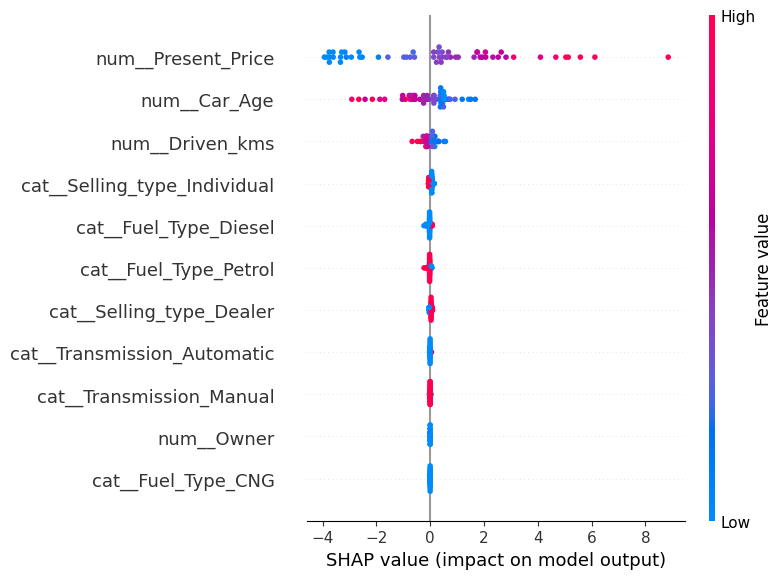

In [11]:
# Feature Importance
feature_names = preprocessor.get_feature_names_out()
explainer = shap.Explainer(best_models["Random Forest"])
shap_values = explainer(X_test_transformed)
shap.summary_plot(shap_values, features=X_test_transformed, feature_names=feature_names)

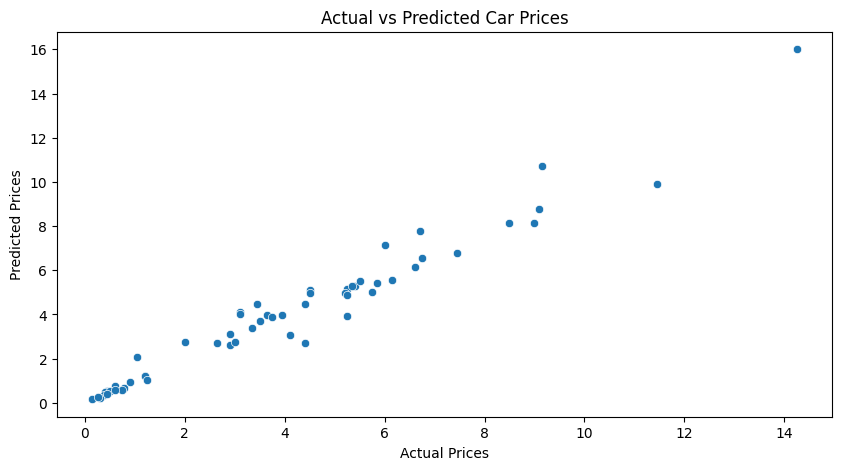

In [12]:
# Visualization
plt.figure(figsize=(10,5))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted Car Prices")
plt.show()

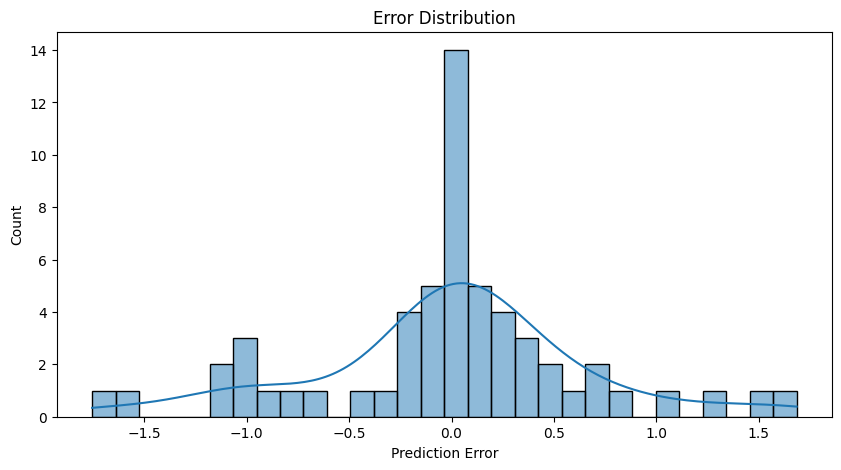

In [13]:
# Error Distribution
plt.figure(figsize=(10,5))
sns.histplot(y_test - y_pred, bins=30, kde=True)
plt.xlabel("Prediction Error")
plt.title("Error Distribution")
plt.show()

In [20]:
# Saving Preprocessor for Future Use
joblib.dump(preprocessor, "preprocessor.pkl")  

['preprocessor.pkl']

## Flask app for prediction

In [ ]:
from flask import Flask, request, jsonify
import pandas as pd
import joblib

app = Flask(__name__)

# Load the trained model
model = joblib.load("random_forest_model.pkl")

# Load the preprocessor
preprocessor = joblib.load("preprocessor.pkl")  

@app.route('/predict', methods=['POST'])
def predict():
    try:
        # Get JSON data from request
        data = request.get_json()
        
        # Convert JSON to DataFrame
        df_input = pd.DataFrame(data, index=[0])
        
        # Transform input data
        df_input_transformed = preprocessor.transform(df_input)
        
        # Make prediction
        prediction = model.predict(df_input_transformed)[0]
        
        # Return predicted price
        return jsonify({"Predicted Price": float(prediction)})

    except Exception as e:
        return jsonify({"error": str(e)})

if __name__ == '__main__':
    app.run(debug=True, use_reloader=False)

 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [17/Feb/2025 02:48:25] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [17/Feb/2025 02:55:51] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [17/Feb/2025 02:58:56] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [17/Feb/2025 03:05:59] "POST /predict HTTP/1.1" 200 -


# How to Test the Flask API

**Option 1: Use a Separate Python File**
- You can test the Flask API by creating a new Python file, for example, `response.py`.
- In this file, use the following code to send a `POST` request to the Flask app and get the predicted price:

**Option 2: Create a separate Jupyter cell**
-  You can test the Flask API by creating a separate Jupyter cell in this file by using the following code.

```python
import requests

url = "http://127.0.0.1:5000/predict"  # Ensure Flask is running at this URL
data = {
    "Fuel_Type": "Petrol",
    "Selling_type": "Dealer",
    "Transmission": "Manual",
    "Present_Price": 5.59,
    "Driven_kms": 27000,
    "Owner": 0, 
    "Car_Age": 5
}

# Send POST request to the Flask API
response = requests.post(url, json=data)

# Print the response from the API
print(response.json())